In [1]:
from qick import *
from qick.rfboard import *

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

import scipy.io

In [2]:
# Load bitstream with custom overlay
soc = RFQickSoc216V1('./qick_rf216_v2.bit', clk_output=None)
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.228
	Firmware timestamp: Wed Jan 31 08:18:41 2024

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	16 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_int4_v1 - envelope memory 4096 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 16-bit D

In [54]:
##################################################
### Square-envelope finite-duration: one pulse ###
##################################################
class PulseTest(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        gen_ch = cfg["gen_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["gen_ch"], nqz=1)
        
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=cfg['gen_ch'])
        gain = cfg["pulse_gain"]
        
        # Set pulse registers.
        self.set_pulse_registers(ch=gen_ch,
                                 style='const',
                                 freq=freq,
                                 phase=0,
                                 phrst=1,
                                 gain=gain,
                                 length=self.us2cycles(cfg['pulse_length'], gen_ch=gen_ch))
        
        self.synci(200)  # give processor some time to configure pulses
        
        # Trigger.
        self.trigger(pins=[0])
        self.synci(200)
    
    def body(self):
        # Pulse.
        self.pulse(ch=self.cfg["gen_ch"])
        
        # Period.
        self.synci(self.us2cycles(self.cfg['period']))        
       
config={"gen_ch"      : 4,
        "reps"        : 3,
        "period"      : 20,
        "style"       : 'const',
        "pulse_length": 11.2,
        "pulse_gain"  : 30000, # [DAC units]
        "pulse_freq"  : 500, # [MHz]
       }

prog = PulseTest(soccfg, config)
prog.config_all(soccfg)

########################
### RF Board Setting ###
########################
freq = config['pulse_freq']
nqz = 1

# Set Nyquist Zone.
dacid = soc['gens'][config['gen_ch']]['dac']
soc.rf.set_nyquist(dacid, nqz=nqz)

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 30)

In [55]:
soc.tproc.start()

In [60]:
#####################################################
### Square-envelope finite-duration: three pulses ###
#####################################################
class PulseTest(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        gen_ch = cfg["gen_ch"][0]

        # set the nyquist zone
        self.declare_gen(ch=cfg["gen_ch"][0], nqz=1)
        
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"][0], gen_ch=cfg['gen_ch'][0])
        gain = cfg["pulse_gain"][0]
        
        # Set pulse registers.
        self.set_pulse_registers(ch=cfg["gen_ch"][0],
                                 style='const',
                                 freq=freq,
                                 phase=0,
                                 phrst=1,
                                 gain=gain,
                                 length=self.us2cycles(cfg['pulse_length'], gen_ch=cfg['gen_ch'][0]))
        
        # set the nyquist zone
        self.declare_gen(ch=cfg["gen_ch"][1], nqz=1)
        
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"][1], gen_ch=cfg['gen_ch'][1])
        gain = cfg["pulse_gain"][1]
        
        # Set pulse registers.
        self.set_pulse_registers(ch=cfg["gen_ch"][1],
                                 style='const',
                                 freq=freq,
                                 phase=0,
                                 phrst=1,
                                 gain=gain,
                                 length=self.us2cycles(cfg['pulse_length'], gen_ch=cfg['gen_ch'][1]))
        
        # set the nyquist zone
        self.declare_gen(ch=cfg["gen_ch"][2], nqz=1)
        
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"][2], gen_ch=cfg['gen_ch'][2])
        gain = cfg["pulse_gain"][2]
        
        # Set pulse registers.
        self.set_pulse_registers(ch=cfg["gen_ch"][2],
                                 style='const',
                                 freq=freq,
                                 phase=0,
                                 phrst=1,
                                 gain=gain,
                                 length=self.us2cycles(cfg['pulse_length'], gen_ch=cfg['gen_ch'][2]))         
        
        self.synci(200)  # give processor some time to configure pulses
        
        # Trigger.
        self.trigger(pins=[0])
        self.synci(200)
    
    def body(self):
        # Pulse.
        self.pulse(ch=self.cfg["gen_ch"][0])
        self.pulse(ch=self.cfg["gen_ch"][1])
        self.pulse(ch=self.cfg["gen_ch"][2])
        
        # Period.
        self.synci(self.us2cycles(self.cfg['period']))        
       
config={"gen_ch"      : [4,5,12],
        "reps"        : 3,
        "period"      : 20,
        "style"       : 'const',
        "pulse_length": 11.2,
        "pulse_gain"  : [30000,20000,10000], # [DAC units]
        "pulse_freq"  : [500,500,3000], # [MHz]
       }

prog = PulseTest(soccfg, config)
prog.config_all(soccfg)

########################
### RF Board Setting ###
########################
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'][0], 15, 30)
soc.rfb_set_gen_rf(config['gen_ch'][1], 0, 30)
soc.rfb_set_gen_rf(config['gen_ch'][2], 10, 30)

# Set filter.
soc.rfb_set_gen_filter(config['gen_ch'][2], fc=2.1, ftype='bypass')

In [61]:
soc.tproc.start()

In [62]:
##################################################
### Long duration signal for spectrum analysis ###
##################################################
class MuxSGTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1,
                         mux_freqs = self.cfg['pulse_freqs'],
                         mux_gains = self.cfg['pulse_gains'])        
        
        # Pulse registers.
        length = self.us2cycles(self.cfg['pulse_length'], gen_ch=self.cfg['gen_ch'])
        self.set_pulse_registers(ch = self.cfg['gen_ch'], style = 'const', length=length, mask=[0,1,2,3])
        
        self.synci(200)
    
    def body(self):
        # Trigger.
        self.trigger(pins=[0],t=40)

        # Pulses.
        self.pulse(ch=self.cfg['gen_ch'])
        self.pulse(ch=self.cfg['gen_ch'])
        self.pulse(ch=self.cfg['gen_ch'])
        self.pulse(ch=self.cfg['gen_ch'])
        self.pulse(ch=self.cfg['gen_ch'])

       
config={"gen_ch"      : 15,
        "reps"        : 1,
        "pulse_length": 5000000, # 5 s
        "pulse_freqs" : [7100,7200,7500,7700],
        "pulse_gains" : [0.6, -0.6, 0.6, -0.6],
        "period"      : 2,
        "phrst"       : 1,
       }

prog = MuxSGTest(soccfg, config)
prog.config_all(soccfg)

########################
### RF Board Setting ###
########################
# Set Nyquist Zone.
nqz = 2
dacid = soc['gens'][config['gen_ch']]['dac']
soc.rf.set_nyquist(dacid, nqz=nqz, blocktype='dac')

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 30)

# Set filter.
soc.rfb_set_gen_filter(config['gen_ch'], fc=3, ftype='bypass')

In [65]:
soc.tproc.start()

In [66]:
soc.rfb_set_gen_rf(config['gen_ch'], 10, 10)
soc.rfb_set_gen_filter(config['gen_ch'], fc=6, ftype='bandpass')

In [7]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'], 
                                     style  = 'const', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'], 
                                     length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phase=0, phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0],
                     t               = self.us2cycles(self.cfg['pulse_start']),
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [5],
        "ro_length"   : 40,
        "ro_freq"     : 4000,
        "ro_offset"   : 0,
        
        "gen_ch"      : 14,        
        "pulse_length": 20,
        "pulse_start" : 10,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 4000,
        
        "reps"        : 1,
        "period"      : 20
       }

########################
### RF Board Setting ###
########################
# Nyquist Zone.
nqz = 2

#######
# DAC #
#######
freq = config['pulse_freq']

# Set Nyquist Zone.
dacid = soc['gens'][config['gen_ch']]['dac']
soc.rf.set_nyquist(dacid, nqz=nqz, blocktype='dac')

# Set Filter.
fc = freq/1000
soc.rfb_set_gen_filter(config['gen_ch'], fc=fc, ftype='bandpass')
#soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 20)

#######
# ADC #
#######
# Set Filter.
fc = freq/1000
soc.rfb_set_ro_filter(config['ro_ch'][0], fc=fc, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'][0], 20)

# Set Nyquist Zone.
adcid = soc['readouts'][config['ro_ch'][0]]['adc']
soc.rf.set_nyquist(adcid, nqz=nqz, blocktype='adc')

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

  0%|          | 0/1 [00:00<?, ?it/s]

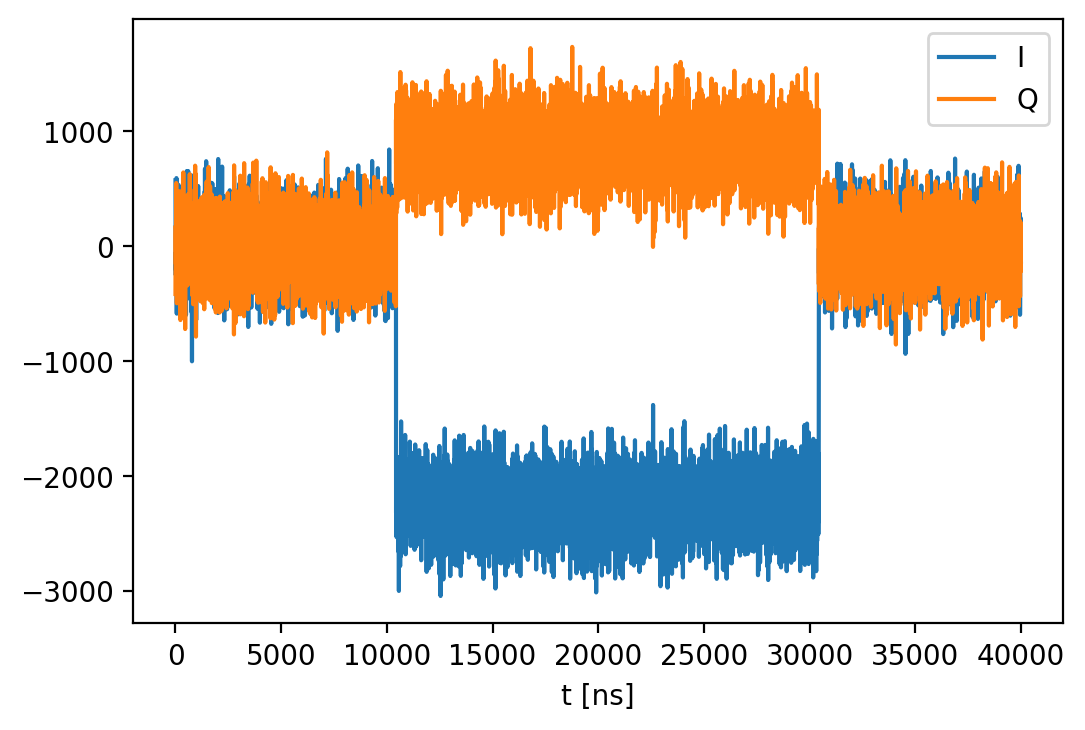

In [8]:
# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
t = ts*np.arange(len(iq_list[0][0]))

plt.plot(t,yi)
plt.plot(t,yq)
#plt.xlim([2005,2040])
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);
#plt.savefig('time_sig_noise.png')

# Save data.
#fn = 'pulse_{}_{}_filter_p20.mat'.format(config['ro_freq'],config['pulse_freq'])
#scipy.io.savemat(fn, {'xi':yi, 'xq':yq, 't':t,'fs':fs})

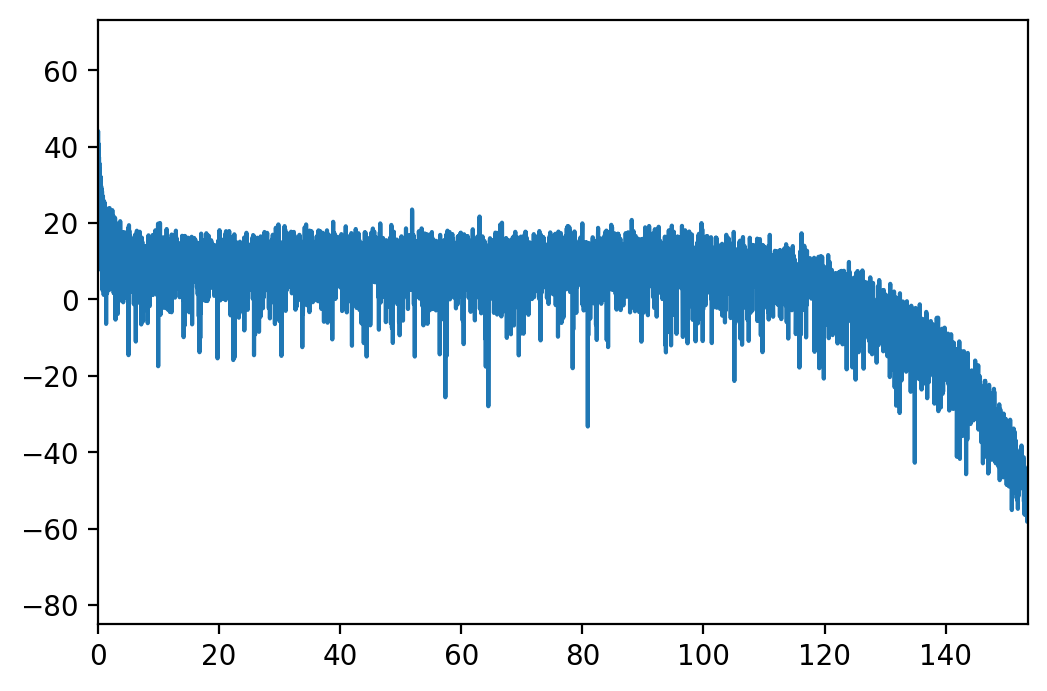

In [63]:
# Plot Spectrum.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = yi + 1j*yq

w = np.hanning(len(x))
xw = x*w
Y = fft(xw)/len(x)
YdB = 20*np.log10(np.abs(Y))
F = np.linspace(0,fs,len(Y))

plt.plot(F, YdB);
plt.xlim([0,fs/2]);
#plt.savefig('spectrum_sig_noise.png')

In [74]:
soc.rfb_set_bias(0,-3)